<a href="https://colab.research.google.com/github/rupeshthapa123/NotebookProject/blob/main/Rupesh_Thapa_Lab3_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Test Statistics

Hypothesis testing relies on our ability to calculate the probability of observing a sample like ours. We calculate this probability by calculating a **test statistic** like a z-score or t-score. From there we can calculate the p-value for that test statistic based on its associated distribution. For the z-score, this is the normal distribution, while for the t-score, this is Student's t-distribution.

This notebook will discuss how to select the appropriate test statistic based on the hypothesis we want to test.

In [ ]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pylab as plt

def plot_hist_dist(rvs, dist, title=None, label='', mean=None, confidence_interval=None, ax=None):
    ax = ax if ax else plt.gca()
    _, bins, _ = ax.hist(rvs, bins=50, alpha=.6, density=True, label=(label + ' rvs').strip(), color='blue')
    xmin, xmax = bins.min(), bins.max()
    xpoints = np.arange(xmin, xmax, (xmax - xmin) / 100)
    ax.plot(xpoints, dist.pdf(xpoints), label=(label+' pdf').strip(), color='black')

    if mean is not None:
        ax.plot([mean, mean], plt.ylim(), label='mean', color='purple')

    if confidence_interval:
        ymid = np.sum(plt.ylim()) / 2.
        plt.text(mean, ymid, 'CI', ha='center', va='bottom')
        plt.annotate("", xy=(confidence_interval[0], ymid), xycoords='data',
                     xytext=(confidence_interval[1], ymid), textcoords='data',
                     arrowprops=dict(arrowstyle="|-|", lw=2, color='r'))

    if title:
        ax.set_title(title)

    ax.legend()

def plot_hist_dist_discrete(rvs, dist, title=None, label='', ax=None):
    ax = ax if ax else plt.gca()
    uniques = np.unique(rvs)
    mids = (uniques[1:] + uniques[:-1]) / 2.
    bins = np.hstack([[uniques[0]-.5], mids, [uniques[-1] + .5]])
    plt.hist(rvs, bins=bins, density=True, label=(label + ' rvs').strip(), alpha=.6, color='blue')
    if title:
        ax.set_title(title)
    plt.plot(uniques, dist.pmf(uniques), label=(label + ' pmf').strip(), color='black')
    ax.legend()

## Random variables and sampling distributions


Common examples of hypothesis testing use hypotheses about population means (e.g. the mean income of unionized construction workers is greater than \$32K/yr). We test the hypothesis by calculating a sample mean

$$ \overline X = \frac{1}{N}\sum_i^N X_i $$

The sample mean is a sum of random variables, meaning the sample mean itself is a random variable. If the sample mean is a random variable, how is the sample mean distributed (i.e. what kind of random variable is it)?

**Short answer:** Because of the Central Limit Theorem, for large N it is approximately normally distributed.
**Long answer:** It depends on what kind of random variables the $X_i$ are...

More precisely, we are interested in what test statistic (and associated sampling distribution) is appropriate based on our hypothesis and our random variate sample.

## Standard Error of Proportion


Sometimes using a normal distribution to approximate a variable does not quite make sense.  For instance, if we are estimating the success rate of a trial with binary outcomes, we can assume the underlying variable $X$ as Bernoulli with a probability of success $p$.  Recall $p$ is also the mean of the Bernoulli so the mean estimator $\hat p$ is easy to compute.  From probability theory, we know that the variance is given by $\sigma^2 = p (1-p)$.

Even though the proportion estimator $\hat p$ will be bound between 0 and 1, we will still model the proportion estimator $\hat p$ as a normal distribution (which is unbounded) with mean $p$ and a standard error
$$ s = \sqrt{\frac{p (1-p)}{n}}\,. $$

At large $n$ this approximation becomes arbitrarily accurate (the probability outside the 0--1 bounds vanishes), but we know that the probability of observing $k$ successes out of $n$ Bernoulli trials each with probability $p$ of success is given exactly by the binomial distribution. We can therefore calculate the p-value of a sample of Bernoulli random variables using the binomial cumulative distribution function.

interactive(children=(FloatSlider(value=0.9, description='p', max=1.0), IntSlider(value=30, description='n', m…

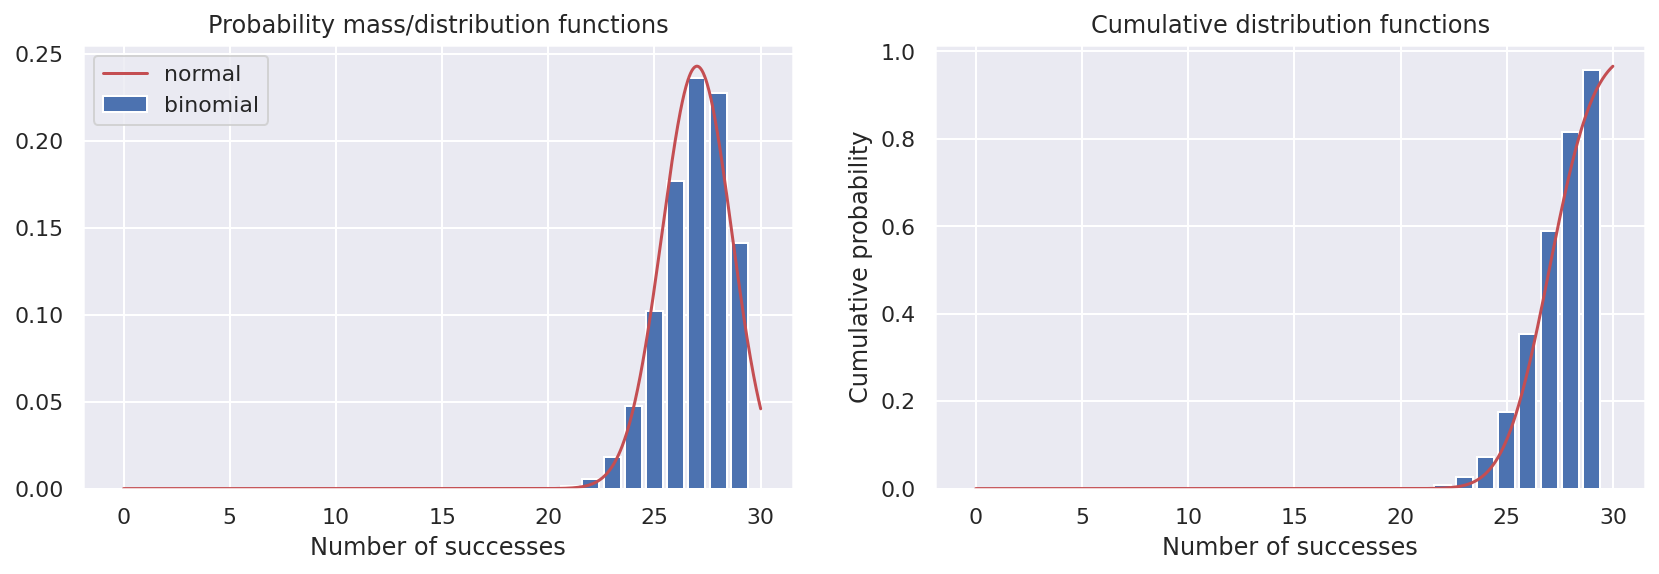

In [ ]:
from ipywidgets.widgets import interact

def binom_norm_comparison_plot(p=0.9, n=30):
    plt.figure(figsize=[14, 4])

    plt.subplot(121)
    plt.bar(range(n), sp.stats.binom.pmf(range(n), n, p), label='binomial')
    plt.plot(np.linspace(0, n, 1000), sp.stats.norm.pdf(np.linspace(0, n, 1000), n*p, np.sqrt(n*p*(1-p))), 'r', label='normal')
    plt.legend()
    plt.title('Probability mass/distribution functions')
    plt.xlabel('Number of successes')

    plt.subplot(122)
    plt.bar(range(n), sp.stats.binom.cdf(range(n), n, p), label='binomial')
    plt.plot(np.linspace(0, n, 1000), sp.stats.norm.cdf(np.linspace(0, n, 1000), n*p, np.sqrt(n*p*(1-p))), 'r', label='normal')
    plt.title('Cumulative distribution functions')
    plt.xlabel('Number of successes')
    plt.ylabel('Cumulative probability')

interact(binom_norm_comparison_plot, p=(0, 1, .1), n=(1, 100, 1));

### Rule of Three

What is the confidence interval if we have not observed a single success over $n$ Bernoulli trials?  Naively, $s$ is zero and so the confidence interval seems trivial, but nonsensical.  Rather than doing that, we ask for what values of $p$ is the likelihood of having observed no events greater than or equal to 5%:
$$ \mathbb{P}[X_1 = \cdots = X_n = 0] \ge 0.05 $$
The left hand side is just $(1-p)^n$, and so taking logs we have
$$ -np \approx n \ln (1-p) \ge \ln(0.05) \approx -3 $$
and so we have
$$ p \lesssim \frac{3}{n} \,.$$

That is, the 95% confidence interval is approximately $\left[0, \frac{3}{n}\right]$.

## Standard Error of Variance Estimate


The Central Limit Theorem tells us that the mean estimator (i.e. a sum of random variables) itself is a random variable that becomes normally distributed as $n$ increases.  How does the variance estimator (or other estimators) behave?  For normally distributed data, the variance estimator (i.e. a sum of squared random variables) behaves as a chi-squared distribution.  The $\chi^2$ distribution with $n$ degrees of freedom is the distribution given by the sum of $n$ independent standard normal distributions squared:

$$ \chi^2(n) \sim \sum_{k=1}^n Z_k^2\,. $$

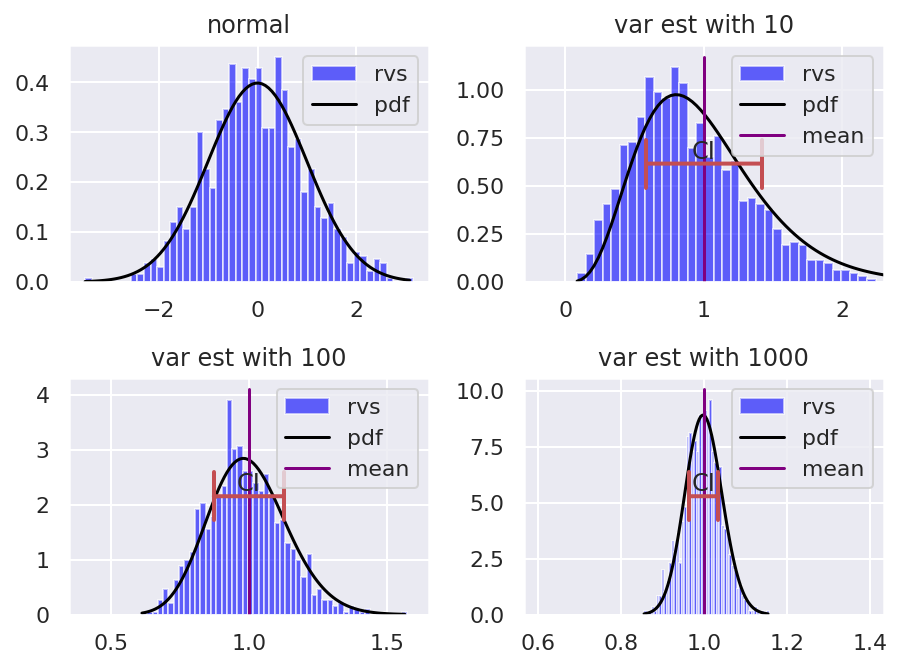

In [ ]:
N = 1000
norm = sp.stats.norm()
sample_sizes = (None, 10, 100, 1000)

for k, sample_size in enumerate(sample_sizes):
    plt.subplot(2,2,k+1)
    if sample_size:
        dist = sp.stats.chi2(df=sample_size, scale=1./sample_size)
        mean, var = dist.stats("mv")
        plot_hist_dist(
            sp.stats.norm().rvs(size=[sample_size, N]).var(axis=0),
            dist,
            mean=mean,
            confidence_interval=[mean - np.sqrt(var), mean + np.sqrt(var)],
            title='var est with {:d}'.format(sample_size),
        )
        plt.xlim([1 - 3./np.log(sample_size), 1 + 3./np.log(sample_size)])
    else:
        plot_hist_dist(norm.rvs(size=N), norm, title='normal')
plt.tight_layout()

## Hypothesis Testing for Counts


If we have a Poisson process, we can apply a $\chi^2$ test to check if the counts equal some expected means.  If we hypothesize $H_0$ that $X_1, \ldots, X_n$ are independent Poisson random variables with expected means $\lambda_1, \ldots, \lambda_n$, we can use this as a basis for hypothesis testing.  Because we know that the mean and variance of $X_k$ is $\lambda_k$, we know that
$$ \frac{(X_k - \lambda_k)^2}{\lambda_k} $$
would be a non-negative random variable with expected value 1.  It asymptotically approaches the square of a standard normal.  Therefore, asymptotically,
$$ \sum_{k=1}^n \frac{(X_k - \lambda_k)^2}{\lambda_k} \sim \chi^2(n-1)$$

Notionally, this is because we are constraining $\sum_k X_k = \sum_k \lambda_k$.
We can easily test our hypothesis $H_0$ by testing the p value and rejecting sufficiently extreme p values.

**Example:** If we have counts broken up by two variables $X_{ij}$, we can apply the above to study independence.  For example, $i$ may denote whether the person is male or female, and $j$ may denote whether they are left handed, right-handed, or ambidextrous.  Then $X_{ij}$ would denote the number of people of that sex and handedness in a sample population.  We can use the $\chi^2$ test to study whether sex and handedness are correlated.  If they are not, we expect the levels to be given by
$$ \lambda_{ij} = \frac{\hat \lambda_{i\cdot} \hat \lambda_{\cdot j}}{\hat  \lambda} $$
where
$$ \hat \lambda_{i\cdot} = \sum_{j'} X_{i j'} \qquad \hat \lambda_{\cdot j} = \sum_{i'} X_{i' j} \qquad \hat \lambda = \sum_{i'j'} \lambda_{i'j'}\,. $$
With a little bit of math, we can see that asymptotically
$$ \sum_{k=1}^n \frac{(X_k - \lambda_k)^2}{\lambda_k} \sim \chi^2((r-1)(c-1))$$
where $r$ is the number of rows (i.e. the number of possible values of $i$; 2 for sex) and $c$ is the number of columns (i.e. the number of possible values of $j$; 3 for handedness).

**Question:** Where else might we use a chi-squared hypothesis test? Why?

A chi-square (χ2) statistic is a test that measures how a model compares to actual observed data. The data used in calculating a chi-square statistic must be random, raw, mutually exclusive, drawn from independent variables, and drawn from a large enough sample. For example, the results of tossing a fair coin meet these criteria.

There are two main kinds of chi-square tests: the test of independence, which asks a question of relationship, such as, "Is there a relationship between student gender and course choice?"; and the goodness-of-fit test, which asks something like "How well does the coin in my hand match a theoretically fair coin?"

Chi-square analysis is applied to categorical variables and is especially useful when those variables are nominal (where order doesn't matter, like marital status or gender).

 Goodness-of-Fit

χ2 provides a way to test how well a sample of data matches the (known or assumed) characteristics of the larger population that the sample is intended to represent. This is known as goodness of fit.

If the sample data do not fit the expected properties of the population that we are interested in, then we would not want to use this sample to draw conclusions about the larger population.

 A chi-square test is used to help determine if observed results are in line with expected results and to rule out that observations are due to chance.

A chi-square test is appropriate for this when the data being analyzed are from a random sample, and when the variable in question is a categorical variable.2 A categorical variable consists of selections such as type of car, race, educational attainment, male or female, or how much somebody likes a political candidate (from very much to very little).

These types of data are often collected via survey responses or questionnaires. Therefore, chi-square analysis is often most useful in analyzing this type of data.
Chi-square is a statistical test used to examine the differences between categorical variables from a random sample in order to judge the goodness of fit between expected and observed results.


## Bootstrapping


Estimating the standard error of an estimate can be difficult.  In general we may not have a suitable analytical approximation for our sampling distribution.  Fortunately we can numerically compute the standard error.  In previous examples, we've numerically computed the error of a parameter estimate by resampling from the entire population.  Sometimes this can be costly, so instead we subsample from the data we have already collected.

**Bootstrapping** involves sampling the data (with replacement), computing the estimator on the sample, and using that to infer *nonparametric* estimates of your confidence interval.  Let's suppose the statistic we want to compute on the data $X_1,\ldots,X_N$ is $\theta(X_1,\ldots,X_N)$.  For example, $\theta$ might be the mean or variance estimators we proposed above.  Next, let's call $\hat \theta_k$ the result of applying $\theta$ on the $k$-th random subsample of the data $X_1,\ldots,X_N$.  Then the variance of the estimator of $\theta$ is given by

$$ \frac{1}{B-1} \sum_{k=1}^B \left( \hat \theta_k - \frac{1}{B} \sum_{j=1}^B \hat \theta_j\ \right)^2\, $$

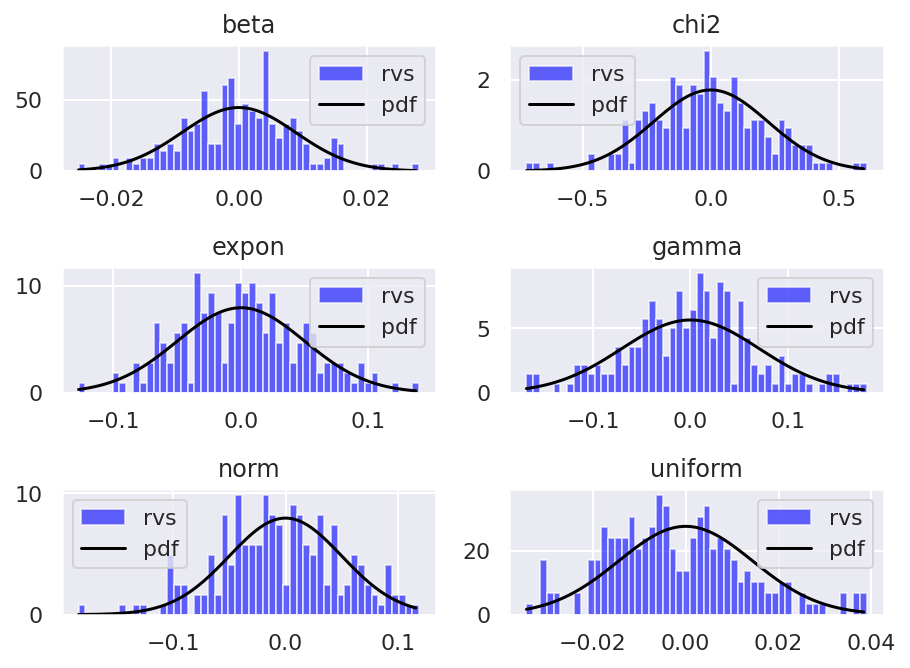

In [ ]:
N = 400
bootstrap_number = 200

def bootstrap_samples(rvs, estimator, bootstrap_number):
    n = len(rvs)
    return np.array([estimator(np.random.choice(rvs, size=n)) for _ in range(bootstrap_number)])

dists = (
    sp.stats.beta(a=2., b=4.),
    sp.stats.chi2(df=10),
    sp.stats.expon(),
    sp.stats.gamma(a=1.99),
    sp.stats.norm(),
    sp.stats.uniform(),
)

for k, dist in enumerate(dists):
    plt.subplot(3,2,k+1)
    mean, var = dist.stats("mv")
    rvs = dist.rvs(size=N)
    samples = bootstrap_samples(
        rvs,
        estimator=lambda x: np.mean(x) - rvs.mean(),
        bootstrap_number=bootstrap_number
    )

    norm = sp.stats.norm(loc=0., scale=np.sqrt(var / (N-1)))
    plot_hist_dist(samples, norm, title=dist.dist.name)

plt.tight_layout()

## Determining Distributions


One common question is to have data $X_1, \ldots, X_n$ and wonder whether it has the same distribution as a hypothetical random variable $Y$.  One way to solve this problem is to take the quantile estimate of the points $X_1, \ldots, X_n$ and compare it to the quantile function $q_Y$ of $Y$.  That is, we plot the sorted points $\underline X_1, \ldots, \underline X_n$ (which form the approximate quantile function) and the points $q_Y(1/n), \ldots, q_Y(1)$ (or those points of the theoretical quantile function for $Y$).  In other words, we're plotting the points
$$ (\underline X_1, q_Y(1/n)), (\underline X_2, q_Y(2/n))\ldots, (\underline X_n, q_Y(1))\,. $$
Remember that $q_Y(U)$ has the same distribution as $Y$ so if $X$ and $Y$ share the same distribution, then these two sets of points (which are quantile approximations) should conform to the straight line $y=x$.

**Practical Usage:**
- It turns out that `scipy` will do this for us using the function `probplot`.
- It will also gives us the $R^2$ of this fit.  The closer to $1$, the more likely $X$ has the distribution of $Y$.
- Finally, don't forget that large quantiles can be noisy, so don't be surprised to see a large amount of variation near the tails.
- These are often called Q-Q plots, for quantile-quantile plots.
- Q-Q plots are very clear but you can also apply the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test, which essentially formulates and automates the testing of Q-Q plots.  This is handled by the function [`scipy.stats.ktest`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html).

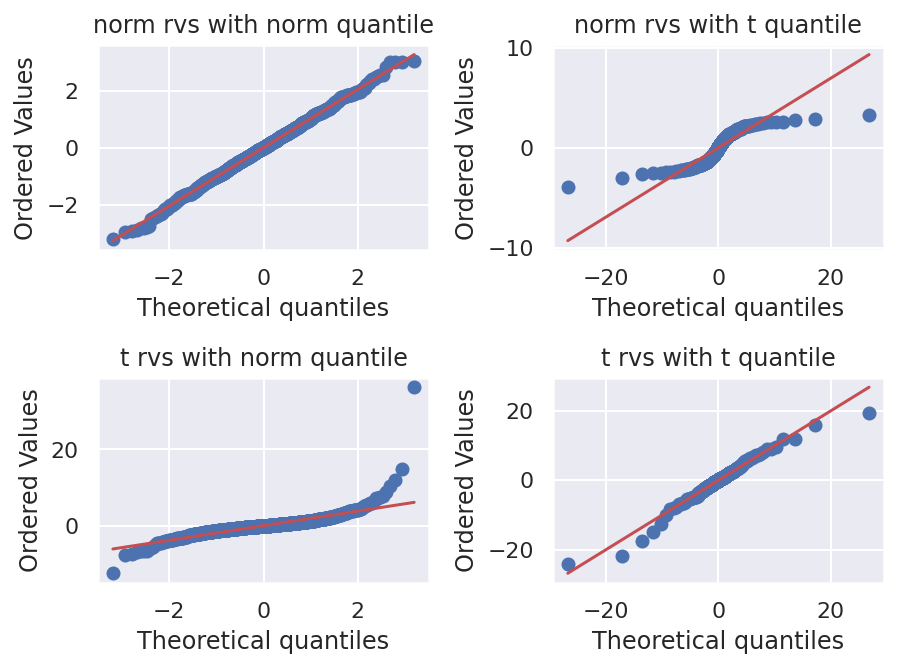

In [ ]:
# Two-sided distributions and their plots

dists = (sp.stats.norm(), sp.stats.t(df=2))

for k, distx in enumerate(dists):
    for j, disty in enumerate(dists):
        plt.subplot(len(dists), len(dists), 1 + len(dists)*k + j)
        rvs = distx.rvs(size=1000)
        sp.stats.probplot(rvs, dist=disty, plot=plt)
        plt.title('{} rvs with {} quantile'.format(distx.dist.name, disty.dist.name))
plt.tight_layout()

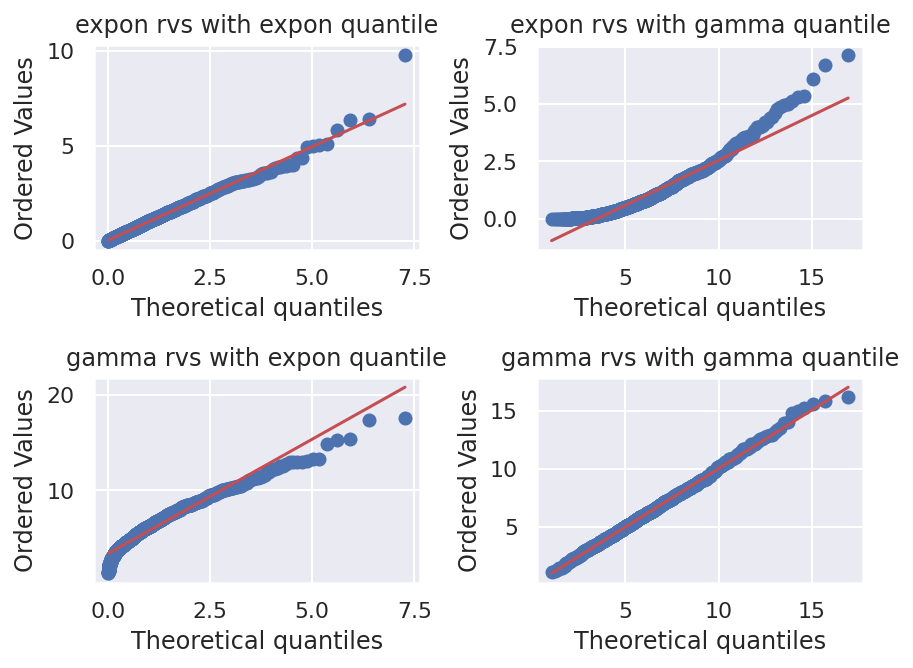

In [ ]:
# One-sided distributions and their plots

dists = (sp.stats.expon(), sp.stats.gamma(6.))

for k, distx in enumerate(dists):
    for j, disty in enumerate(dists):
        plt.subplot(len(dists), len(dists), 1 + len(dists)*k + j)
        rvs = distx.rvs(size=1000)
        sp.stats.probplot(rvs, dist=disty, plot=plt)
        plt.title('{} rvs with {} quantile'.format(distx.dist.name, disty.dist.name))
plt.tight_layout()

# Questions.

1. Write the Central Limit Theorem

2. What is the relation between Bernoulli and Binomial distribution?

3. How are Exponential and Gamma distributions different?

#Central Limit Theorem

Central limit theorem states that the distribution of a sample variable approximates a normal distribution as the sample size becomes larger, assuming that all samples are identical in size, and regardless of the populations actual distribution shape. In another word it means given a large sample size from a population with a finite level of variance, the mean of all sampled variables from the same population will be approximately equal to the mean of whole population.

The CLT is useful when a large data sets has to be analyzed because it allows one to assume that the sampling distribution of the mean will be normally distibuted in most cases.

CLT formula:

We can describe the sampling distribution of the mean using this notation:

  $$\bar{X}\sim N (\mu,\dfrac{\sigma}{\sqrt{n}})$$

- X̄ is the sampling distribution of the sample means
- ~ means “follows the distribution”
- N is the normal distribution
- µ is the mean of the population
- σ is the standard deviation of the population
- n is the sample size

# Relation between Bernoulli and Binomial Distribution

Bernoulli random variable has two possible outcomes:0 or 1 and only one trial.
Bernoulli is represented as $$Bernoulli (p)$$

In the above image, "p" represents the probability of the event to occur. For Example probability of getting head in a coin toss.

Probability Mass Function (PMF)

The formula for pmf associated with a Bernoulli random variable over possible outcomes 'x' is given as follows:
$$P(x) = p^x * (1-p)^{(1-x)}$$

The mean and the variance of the distribution are p and p(1 − p), respectively.

And Binomial distribution is the sum of independent and identically distributed Bernoulli random variables. It means it is the collection of bernoulli trials for the same event.

It can be represented using:
$$Binomial(n,p)$$

In the above image, "n" represents the number of Bernoulli trials, & "p" represents the probability of event in each trial.

Probability Function to calculate Binomial Distribution!
$$Probability(event) = C^n_s * p^s * (1-p)^{n-s}   $$

In the above equation:
- “n” is the total number of trials of an event.
- “s” corresponds to the number of times an event should occur.
- “p” is the probability that the event will occur.
- “(1 — p)” is the probability that the event will not occur.
- “C” term is for combinations.

# Difference between Gamma and Exponential Distributions
In probability theory, the exponential distribution is defined as the probability distribution of time between events in the Poisson point process. The exponential distribution is considered as a special case of the gamma distribution.

The exponential distribution is a continuous probability distribution that often concerns the amount of time until some specific event happens. It is a process in which events happen continuously and independently at a constant average rate. The exponential distribution has the key property of being memoryless. The exponential random variable can be either more small values or fewer larger variables. For example, the amount of money spent by the customer on one trip to the supermarket follows an exponential distribution.

The continuous random variable, say X is said to have an exponential distribution, if it has the following probability density function:
$$
 f(x;\lambda )={\begin{cases}\lambda e^{-\lambda x}&x\geq 0,\\0&x<0.\end{cases}}
$$
Here λ > 0 is the parameter of the distribution, often called the rate parameter.

The gamma distribution is a continuous probability distribution that models right-skewed data. Additionally, the gamma distribution is similar to the exponential distribution, and you can use it to model the same types of phenomena: failure times, wait times, service times, etc. The most frequent use case for the gamma distribution is to model the time between independent events that occur at a constant average rate. Using this distribution, analysts can specify the number of events, such as modeling the time until the 2nd or 3rd accident occurs.

The gamma distribution is a generalization of the exponential distribution. The gamma distribution can model the elapsed time between various numbers of events. Conversely, the exponential distribution can model only the time until the next event, such as the next accident.

The corresponding probability density function in the shape-rate parameterization is
   $${\displaystyle {\begin{aligned}f(x;\alpha ,\beta )&={\frac {x^{\alpha -1}e^{-\beta x}\beta ^{\alpha }}{\Gamma (\alpha )}}\quad {\text{ for }}x>0\quad \alpha ,\beta >0,\\[6pt]\end{aligned}}}$$

where $${\displaystyle \Gamma (\alpha )}$$ is the gamma function. For all positive integers, Γ ( α ) = ( α − 1 ) !
